<a href="https://colab.research.google.com/github/themaxempire23/DeepLearning/blob/main/Waste_Management_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Our Setup and Data Loading**

In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data bold text Loading and Preprocessing**

In [9]:
# Import necessary libraries
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Define the dataset path
dataset_path = '/content/drive/My Drive/Recyclable Waste Images Dataset/images'

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor()
])

# Load dataset using ImageFolder
dataset = ImageFolder(root=dataset_path, transform=transform)

# Optimized check for duplicates based on file paths
def remove_duplicates(dataset):
    unique_samples = []
    seen_paths = set()
    for sample in dataset.samples:
        if sample[0] not in seen_paths:
            unique_samples.append(sample)
            seen_paths.add(sample[0])
    dataset.samples = unique_samples

remove_duplicates(dataset)

## **Data Splitting**

In [10]:
# Import necessary libraries
from torch.utils.data import Subset
import numpy as np

# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Split dataset into training, validation, and test sets
train_size = int(0.75 * len(dataset))
val_test_size = len(dataset) - train_size
val_size = val_test_size // 2
test_size = val_test_size - val_size

indices = list(range(len(dataset)))
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# **Some Visualized Samples**

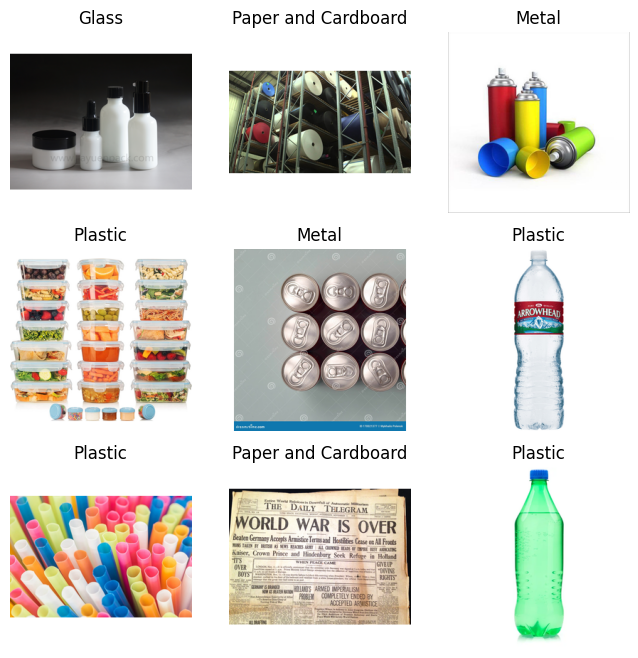

In [11]:
labels_map = {
    0: "Glass",
    1: "Metal",
    2: "Organic Waste",
    3: "Paper and Cardboard",
    4: "Plastic",
    5: "Styrofoam",
    6: "Textiles"
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()


# **Model Development**

In [12]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the CNN model
class WasteClassifier(nn.Module):
    def __init__(self):
        super(WasteClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, 7)  # Assuming 7 classes: Glass, Metal, Organic Waste, Paper and Cardboard, Plastic, Styrofoam, Textiles

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 64 * 64)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = WasteClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# **Training the Model**

In [ ]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Validation Loss: {val_loss/len(val_loader)}")


# **Evaluation and Metrics**

In [1]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


NameError: name 'model' is not defined